In [2]:
# goal: have sympy do the mechanical substitutions, to double-check the desired relations
# once this is done, this will also make it easier for a human to check (just double-check the definitions), and easier
# to check for arbitrary splittings

from sympy import *
from sympy import init_printing
init_printing()

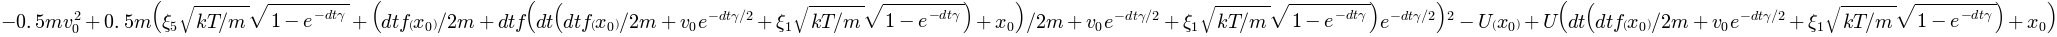

In [4]:
symbolic_traj = dict()
symbolic_traj['x_0'] = symbols('x_0')
symbolic_traj['v_0'] = symbols('v_0')
dt = symbols('dt')
m = symbols('m')
gamma = symbols('gamma')
f = symbols('f')
kT = symbols('kT')
U = symbols('U')

def count_steps(splitting="OVRVO"):
    n_O = sum([step == "O" for step in splitting])
    n_R = sum([step == "R" for step in splitting])
    n_V = sum([step == "V" for step in splitting])
    return n_O, n_R, n_V

def create_variable_names(i):    
    name_x = 'x_{}'.format(i)
    name_v = 'v_{}'.format(i)
    
    symbolic_traj[name_x] = symbols(name_x)
    symbolic_traj[name_v] = symbols(name_v)
    
    x = symbolic_traj['x_{}'.format(i-1)]
    v = symbolic_traj['v_{}'.format(i-1)]
    
    return x, v, name_x, name_v

def apply_R(i, h):
    x, v, name_x, name_v = create_variable_names(i)
    
    symbolic_traj[name_x] = x + v * h
    symbolic_traj[name_v] = v

def apply_V(i, h):
    x, v, name_x, name_v = create_variable_names(i)
    
    symbolic_traj[name_x] = x
    symbolic_traj[name_v] = v + f(x) * h / m
    
def apply_O(i, h):
    a = exp(-gamma * h)
    b = sqrt(1 - exp(-2 * gamma * h))
    
    x, v, name_x, name_v = create_variable_names(i)
    
    symbolic_traj[name_x] = x
    symbolic_traj[name_v] = a * v + b * sqrt(kT / m) * symbols('xi_{}'.format(i))
    # xi_i is an i.i.d. standard normal r.v.
    
def total_energy(x, v):
    return U(x) + (0.5 * m * v**2)

def get_total_energy_at_step(i):
    x = symbolic_traj['x_{}'.format(i)]
    v = symbolic_traj['v_{}'.format(i)]
    return total_energy(x, v)
    
def apply_integrator(i, splitting="OVRVO"):
    heat, W_shad = 0, 0
    
    n_O, n_R, n_V = count_steps(splitting)
    
    for step in splitting:
        if step == "O":
            apply_O(i, dt / n_O)
            heat += get_total_energy_at_step(i) - get_total_energy_at_step(i-1)
        elif step == "R":
            apply_R(i, dt / n_R)
            W_shad += get_total_energy_at_step(i) - get_total_energy_at_step(i-1)
        elif step == "V":
            apply_V(i, dt / n_V)
            W_shad += get_total_energy_at_step(i) - get_total_energy_at_step(i-1)
        i += 1
        
    return heat, W_shad

splitting = "OVRVO"
heat, W_shad = apply_integrator(1, splitting)
delta_E = get_total_energy_at_step(len(splitting)) - get_total_energy_at_step(0)

delta_E

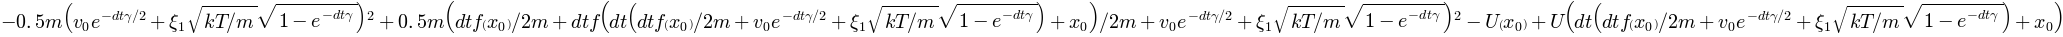

In [5]:
W_shad

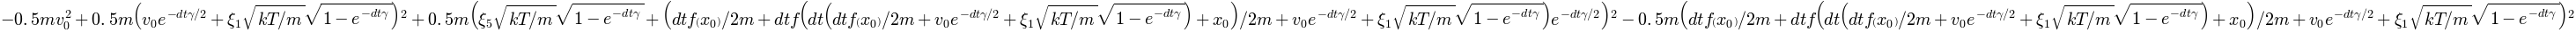

In [6]:
heat

In [7]:
delta_E - (W_shad + heat)

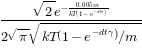

In [9]:
# also define path probabilities?


# here, let's define the individual step probabilities
def normal_pdf(x, mu, sigma):
    return (1 / (sqrt(2 * pi * sigma**2))) * exp(-(x - mu)**2 / (2 * sigma**2))

def R_prob(from_x, from_v, to_x, to_v, h):
    '''deterministic position update'''
    if (from_v == to_v) and (to_x == (from_x + from_v * h)):
        return 1
    else:
        return 0

def V_prob(from_x, from_v, to_x, to_v, h):
    if (from_x == to_x) and (to_v == (from_v + f(from_x) * h / m)):
        return 1
    else:
        return 0

def O_prob(from_x, from_v, to_x, to_v, h):
    ''' need to double check this, probably dropped a 2 somewhere...'''
    a = exp(-gamma * h) # okay
    b = sqrt(1 - exp(-2 * gamma * h)) # okay
    
    sigma = b * sqrt(kT / m) # double-check this! is this the definition of sigma or sigma^2?
    mu = a * from_v # okay
    
    if (from_x == to_x):
        return normal_pdf(to_v, mu, sigma) 
    else:
        return 0

# for example, what's the probability of a small v perturbation
O_prob(0, 0, 0, 0.1, dt / 2) 

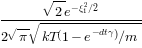

In [11]:
O_prob(symbolic_traj['x_0'], symbolic_traj['v_0'], symbolic_traj['x_1'], symbolic_traj['v_1'], dt / 2)

In [21]:
def forward_path_probability(splitting="OVRVO"):
    path_prob = 1
    n_O, n_R, n_V = count_steps(splitting)
    
    
    
    
    for i, step in enumerate(splitting):
        x_0, v_0 = symbolic_traj['x_{}'.format(i)], symbolic_traj['v_{}'.format(i)]
        x_1, v_1 = symbolic_traj['x_{}'.format(i+1)], symbolic_traj['v_{}'.format(i+1)]
        
        if step == "O":
            step_prob = O_prob(x_0, v_0, x_1, v_1,
                               dt / n_O)
        elif step == "R":
            step_prob = R_prob(x_0, v_0, x_1, v_1,
                               dt / n_R)
        elif step == "V":
            step_prob = V_prob(x_0, v_0, x_1, v_1,
                               dt / n_V)

        path_prob = path_prob * step_prob
    return path_prob

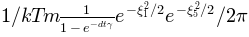

In [22]:
forward_path_probability("OVRVO")

In [34]:
def reverse_path_probability(splitting="OVRVO"):
    '''same as above, just reverse order of trajectory and steps appropriately?'''
    
    path_prob = 1
    n_O, n_R, n_V = count_steps(splitting)

    for i in range(len(splitting))[::-1]:
        step = splitting[i]
        
        
        x_0, v_0 = symbolic_traj['x_{}'.format(i+1)], symbolic_traj['v_{}'.format(i+1)]
        x_1, v_1 = symbolic_traj['x_{}'.format(i)], symbolic_traj['v_{}'.format(i)]
        
        if step == "O":
            step_prob = O_prob(x_0, v_0, x_1, v_1,
                               dt / n_O)
        elif step == "R":
            step_prob = R_prob(x_0, v_0, x_1, v_1,
                               dt / n_R)
        elif step == "V":
            step_prob = V_prob(x_0, v_0, x_1, v_1,
                               dt / n_V)

        path_prob = path_prob * step_prob
    return path_prob

In [35]:
def CFT_definition_of_work(splitting="OVRVO"):
    return - ln(reverse_path_probability(splitting) / forward_path_probability(splitting))

In [36]:
CFT_definition_of_work("OVRVO")

In [37]:
reverse_path_probability()

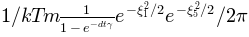

In [38]:
forward_path_probability()

In [ ]:
# hmm that doesn't look quite right